<a href="https://colab.research.google.com/github/christinawanggg/ait-dl-deepfake/blob/main/AIT_DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# AIT - Deep Learning Fall 2021
# Final Project
# Scaffolding and assignment completed by Christina Wang and Isabel Grondin

In [1]:
# Loading Libraries
import numpy as np 
import pandas as pd 
import zipfile
from math import sqrt
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import os
import tensorflow as tf
from keras.preprocessing import image
from keras.utils import np_utils
from skimage.transform import resize
from PIL import Image

from tensorflow import keras
model = tf.keras.models.Sequential()


# Data Set

*   Celeb Deepfake 1: https://drive.google.com/file/d10NGF38RgF8FZneKOuCOdRIsPzpC7_WDd/view


The Celeb Deepfake 1 dataset includes a combination of 1203 real and fake/synthesized videos of celebrities from Youtube. The current state of our project is utilizing this data set.

## Data Extraction

First, we needed to extract all of the videos in the data from a zip file.



In [2]:
# Imports needed for data extraction
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile


In [3]:
# using Pydrive to connect to Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

In [4]:
file_id = "10NGF38RgF8FZneKOuCOdRIsPzpC7_WDd"
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % file_id}).GetList()

In [5]:
downloaded = drive.CreateFile({'id': "10NGF38RgF8FZneKOuCOdRIsPzpC7_WDd"})
downloaded.GetContentFile('Celeb-DF.zip')

In [6]:
# extracting all the videos from the zip file

zip = zipfile.ZipFile("Celeb-DF.zip")
zip.extractall()
videoNameList = zip.namelist()

# Data Pre-Processing

We parsed the videos into individual jpg frames. We then resized and cropped the images so that they all shared the same dimensions. Finally, we extracted the images into a pixel array format and flattened the shape of all the images. 

In [7]:
# Imports needed for standardizing data set
import cv2
import math
from PIL import Image

In [8]:
# Cleaning up the data set

videoNameList.remove("Celeb-real/")
videoNameList.remove("Celeb-synthesis/")
videoNameList.remove("YouTube-real/")
videoNameList.remove("List_of_testing_videos.txt")

print(videoNameList)

['Celeb-real/id0_0000.mp4', 'Celeb-real/id0_0001.mp4', 'Celeb-real/id0_0002.mp4', 'Celeb-real/id0_0003.mp4', 'Celeb-real/id0_0004.mp4', 'Celeb-real/id0_0005.mp4', 'Celeb-real/id0_0006.mp4', 'Celeb-real/id0_0007.mp4', 'Celeb-real/id0_0008.mp4', 'Celeb-real/id0_0009.mp4', 'Celeb-real/id10_0000.mp4', 'Celeb-real/id10_0001.mp4', 'Celeb-real/id10_0002.mp4', 'Celeb-real/id10_0003.mp4', 'Celeb-real/id10_0004.mp4', 'Celeb-real/id10_0005.mp4', 'Celeb-real/id10_0006.mp4', 'Celeb-real/id10_0007.mp4', 'Celeb-real/id10_0008.mp4', 'Celeb-real/id10_0009.mp4', 'Celeb-real/id11_0000.mp4', 'Celeb-real/id11_0001.mp4', 'Celeb-real/id11_0002.mp4', 'Celeb-real/id11_0003.mp4', 'Celeb-real/id11_0004.mp4', 'Celeb-real/id11_0005.mp4', 'Celeb-real/id11_0006.mp4', 'Celeb-real/id11_0007.mp4', 'Celeb-real/id11_0008.mp4', 'Celeb-real/id11_0009.mp4', 'Celeb-real/id11_0010.mp4', 'Celeb-real/id12_0000.mp4', 'Celeb-real/id12_0001.mp4', 'Celeb-real/id12_0002.mp4', 'Celeb-real/id12_0003.mp4', 'Celeb-real/id12_0004.mp4', '

In [9]:
# Extracting an individual frame or jpg image from each video

videos_dict = {} # used to see both the video name and resulting filename
videos_frames = []
videos_listY = [] # serving as our 'Y'
count = 0

for i in range(len(videoNameList)):
  videoFile = "/content/" + videoNameList[i]
  cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
  frameRate = cap.get(5) # frame rate
  x=1
  frameId = cap.get(1) # current frame number
  ret, frame = cap.read()
  if (frameId % math.floor(frameRate) == 0):
      filename ="frame%d.jpg" % count;count+=1
      cv2.imwrite(filename, frame)
      videos_dict[videoNameList[i]] = filename
      videos_frames.append(filename) 
  if 'real' in videoNameList[i]:
    videos_listY.append(1)
  elif 'synthesis' in videoNameList[i]:
    videos_listY.append(0)
cap.release()

print(videos_dict)
print(videos_frames)
print(videos_listY)

{'Celeb-real/id0_0000.mp4': 'frame0.jpg', 'Celeb-real/id0_0001.mp4': 'frame1.jpg', 'Celeb-real/id0_0002.mp4': 'frame2.jpg', 'Celeb-real/id0_0003.mp4': 'frame3.jpg', 'Celeb-real/id0_0004.mp4': 'frame4.jpg', 'Celeb-real/id0_0005.mp4': 'frame5.jpg', 'Celeb-real/id0_0006.mp4': 'frame6.jpg', 'Celeb-real/id0_0007.mp4': 'frame7.jpg', 'Celeb-real/id0_0008.mp4': 'frame8.jpg', 'Celeb-real/id0_0009.mp4': 'frame9.jpg', 'Celeb-real/id10_0000.mp4': 'frame10.jpg', 'Celeb-real/id10_0001.mp4': 'frame11.jpg', 'Celeb-real/id10_0002.mp4': 'frame12.jpg', 'Celeb-real/id10_0003.mp4': 'frame13.jpg', 'Celeb-real/id10_0004.mp4': 'frame14.jpg', 'Celeb-real/id10_0005.mp4': 'frame15.jpg', 'Celeb-real/id10_0006.mp4': 'frame16.jpg', 'Celeb-real/id10_0007.mp4': 'frame17.jpg', 'Celeb-real/id10_0008.mp4': 'frame18.jpg', 'Celeb-real/id10_0009.mp4': 'frame19.jpg', 'Celeb-real/id11_0000.mp4': 'frame20.jpg', 'Celeb-real/id11_0001.mp4': 'frame21.jpg', 'Celeb-real/id11_0002.mp4': 'frame22.jpg', 'Celeb-real/id11_0003.mp4': 'f

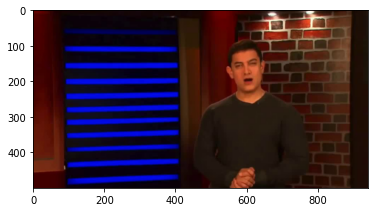

In [10]:
# Displaying a real image

img = plt.imread('frame0.jpg')
plt.imshow(img)


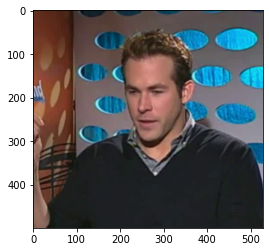

In [11]:
# Displaying a fake image

img2 = plt.imread('frame628.jpg')
plt.imshow(img2)


In [12]:
# comparing the attributes of the real vs fake image
#print("Mode - Img-real: ", imgpil.mode, " Img-fake: ", img2pil.mode)
#print("Size - Img-real: ", imgpil.size, " Img-fake: ", img2pil.size)
#print("Palette - Img-real: ", imgpil.palette, " Img-fake: ", img2pil.palette)
# This failed...

In [90]:
# Standardizing the mode of the images 

def changeColor(colorType, dataset):
  sizes = {}
  for i in range(len(videos_frames)):
    curr_image = Image.open(dataset[i])
  
    # if curr_image.mode != 'RGB':
    png = curr_image.convert(colorType)
    background = Image.new(colorType, png.size, (255))
    png.save(data_set[i])

    # alpha_composite = Image.alpha_composite(background, png)
    sizes[data_Set[i]] = curr_image.size

#print(sizes)
#print(len(sizes))



354
frame72.jpg


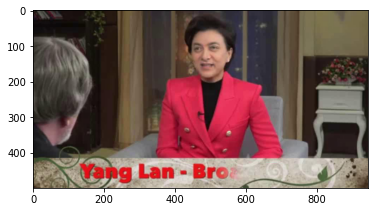

In [14]:
# Extracting the minimum size to know what to use as
# a resize parameter for the thumbnail method of image resizing

min = 100000
minkey = 0

for key,value in sizes.items():
  if sizes[key][0] < min:
    min = sizes[key][0]
    minkey = key

print(min)
print(minkey)
img2 = plt.imread(key)
plt.imshow(img2)

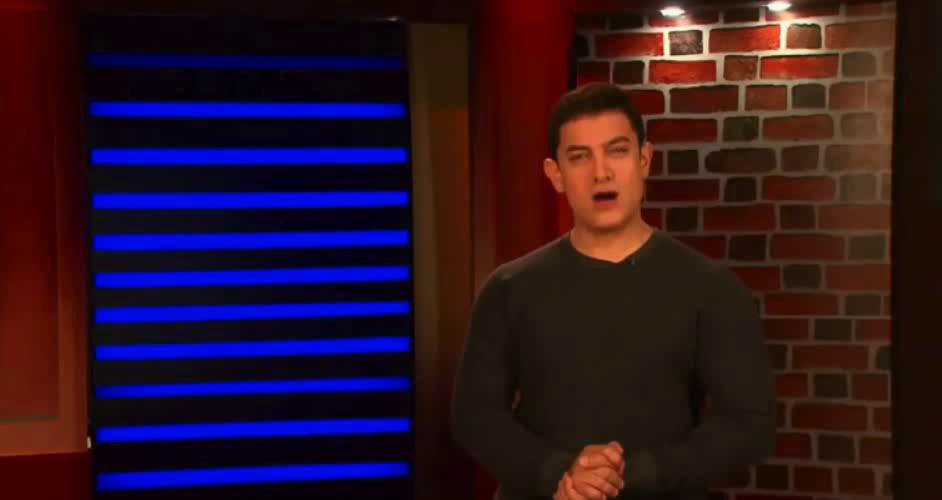

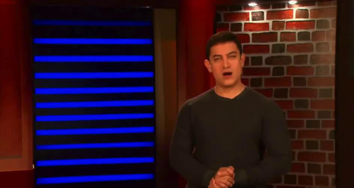

(354, 188)


In [15]:
# resizing a test image (frame0.jpg) 

im0 = Image.open("frame0.jpg")

display(im0)
im0.thumbnail((354,500))
display(im0)

print(im0.size)

In [16]:
# Resizing all of the images using the thumbnail method

for key,value in videos_dict.items():
  im0 = Image.open(videos_dict[key])

  im0.thumbnail((354,500))
  im0.save(videos_dict[key])
  

In [17]:
# Storing the dimensions of all of the data in img_shapes for later usage

img_shapes = []

for key,value in videos_dict.items():
  newim = Image.open(videos_dict[key])
  data = np.array(newim)
  img_shapes.append(data.shape)


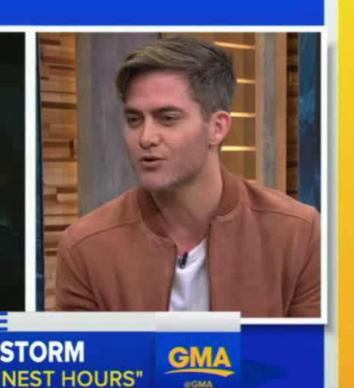

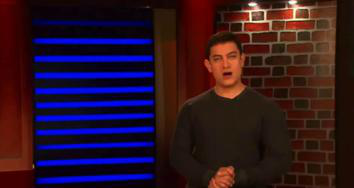

In [18]:
# As you can see, even though we reshaped using the thumbnail method,
# some images, still don't have the same dimensions

img = Image.open('frame315.jpg')
display(img)

img2 = Image.open('frame0.jpg')
display(img2)

In [19]:
# Since not all of the shapes of the images match, we want to crop the larger
# photos at the center, scaling them all down to the same shape
# We chose not to use the resize method to keep the proportions the same

videos_datalist = []

for key,value in videos_dict.items():
  im = Image.open(videos_dict[key])
  width, height = im.size   # Get dimensions

  left = (width - 354)/2
  top = (height - 188)/2
  right = (width + 354)/2
  bottom = (height + 188)/2

  # Crop the center of the image
  im = im.crop((left, top, right, bottom))
  data = np.array(im)
  videos_datalist.append(data)

### Splitting The Data

Splitting the data into train and test sets.


In [74]:
# Imports needed to split the data
from sklearn.model_selection import train_test_split

In [75]:
# do a train-test split
X_train, X_test, Y_train, Y_test = train_test_split(videos_datalist, videos_listY, test_size=0.4, random_state=2)

In [76]:
# converting lists to numpy arrays

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [77]:
# convert to float after resizing images

X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255

## Training the Data

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model # Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import backend as K
import numpy as np


# CNN
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

In [25]:
print('# images in X_train: ', len(X_train))
print('# images in X_test: ', len(X_test))


# images in X_train:  721
# images in X_test:  482


In [89]:
# checking whether its greyscale or rgb

img = Image.open('frame10.jpg').convert('L')
img = Image.open('frame9.jpg')
print(img.getpixel((5,5)))

# print(r, g, b)

(94, 94, 94)


In [ ]:
# reshaping data (# images in set, 354, 188, 1)
# 1 is greyscale --> using RGB later may improve it

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [28]:
X_train.shape 

(721, 188, 354, 3)

In [31]:
# Using InceptionV3 model as a base
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                         

In [33]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

In [34]:
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True) # early stopping avoids overfitting

In [35]:
## Adding augmented data
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True,
                                   shear_range=0.2, validation_split=0.2)
img_height = 188
img_width  = 354
X_train_update = X_train[:, :, 0]
train_generator = train_datagen.flow(X_train, Y_train, batch_size=20, subset='training')
validation_generator = train_datagen.flow(X_train, Y_train, batch_size=20, subset='validation')


In [37]:
# Model with augmentation
model.fit(train_generator, epochs=10000000, callbacks=[es], validation_data=validation_generator)

Epoch 1/10000000
29/29 [==============================] - 18s 613ms/step - loss: 0.6542 - accuracy: 0.6551 - val_loss: 0.6599 - val_accuracy: 0.6389
Epoch 2/10000000
29/29 [==============================] - 17s 593ms/step - loss: 0.6616 - accuracy: 0.6482 - val_loss: 0.6551 - val_accuracy: 0.6389
Epoch 3/10000000
29/29 [==============================] - 17s 590ms/step - loss: 0.6450 - accuracy: 0.6499 - val_loss: 0.6571 - val_accuracy: 0.6389
Epoch 4/10000000
29/29 [==============================] - 17s 588ms/step - loss: 0.6413 - accuracy: 0.6586 - val_loss: 0.8232 - val_accuracy: 0.5486
Epoch 5/10000000
29/29 [==============================] - 17s 590ms/step - loss: 0.6395 - accuracy: 0.6499 - val_loss: 0.6726 - val_accuracy: 0.6389
Epoch 6/10000000
29/29 [==============================] - 17s 589ms/step - loss: 0.6373 - accuracy: 0.6620 - val_loss: 0.6573 - val_accuracy: 0.6389
Epoch 7/10000000
29/29 [==============================] - 18s 600ms/step - loss: 0.6327 - accuracy: 0.6655

In [38]:
model.evaluate(X_test, Y_test)
## Note to prof: We are suprised that this model is getting the exact same
## accuracy as the percentage of fake images in the test set. We were wondering
## if you see an error in logic or if this is because we are only using one image
## for each of the videos.

16/16 [==============================] - 8s 268ms/step - loss: 60.0874 - accuracy: 0.6701


[60.08735275268555, 0.6701244711875916]

In [53]:
# Percentage of real to fake images in the test set
fake = 0
real = 0
for i in range(len(Y_test)):	
  if Y_test[i] == 0:		
    fake += 1
  elif Y_test[i] == 1:	
    real += 1
    
print("fake: ", fake, "real: ", real)

print("Real: ", 159/(482))
print("Fake: ", 1- (159/(482)))

482
482
fake:  323 real:  159
Real:  0.32987551867219916
Fake:  0.6701244813278009


In [54]:
# Model without data augmentation
model.fit(X_train, Y_train, epochs=10000000, callbacks=[es], validation_split = .2)

Epoch 1/10000000
18/18 [==============================] - 22s 772ms/step - loss: 0.6442 - accuracy: 0.6632 - val_loss: 37.7894 - val_accuracy: 0.6207
Epoch 2/10000000
18/18 [==============================] - 14s 758ms/step - loss: 0.6381 - accuracy: 0.6632 - val_loss: 2.8616 - val_accuracy: 0.4207
Epoch 3/10000000
18/18 [==============================] - 14s 763ms/step - loss: 0.6475 - accuracy: 0.6615 - val_loss: 0.6854 - val_accuracy: 0.6276
Epoch 4/10000000
18/18 [==============================] - 14s 764ms/step - loss: 0.6372 - accuracy: 0.6684 - val_loss: 0.6063 - val_accuracy: 0.6828
Epoch 5/10000000
18/18 [==============================] - 14s 756ms/step - loss: 0.6288 - accuracy: 0.6771 - val_loss: 2.6260 - val_accuracy: 0.4276
Epoch 6/10000000
18/18 [==============================] - 14s 757ms/step - loss: 0.6195 - accuracy: 0.6736 - val_loss: 2.4945 - val_accuracy: 0.4621
Epoch 7/10000000
18/18 [==============================] - 14s 758ms/step - loss: 0.6252 - accuracy: 0.666

In [ ]:
# Note to Prof: We were wondering if you have any insight into why the val_loss
# is so strange. Do you think this is becasue of an error in logic?

In [55]:
model.evaluate(X_test, Y_test)

16/16 [==============================] - 3s 200ms/step - loss: 0.6382 - accuracy: 0.6660


[0.6381642818450928, 0.6659750938415527]

In [ ]:
# First model attempt

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# CNN model
old_model = Sequential()
old_model.add(Conv2D(16, 10, input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3],), # (721, 188, 354)
                activation='relu', kernel_initializer='he_normal'))  # output filter size = 6x6, kernel size = 5x5
old_model.add(BatchNormalization())  #improves results
old_model.add(MaxPool2D()) #pooling
old_model.add(Dropout(0.25))
old_model.add(Conv2D(32, 10, activation='relu', kernel_initializer='he_normal'))
old_model.add(BatchNormalization())
old_model.add(Dropout(0.25))

##
old_model.add(Flatten()) # flatten to go into the fully connected model
old_model.add(Dense(60, activation='relu', kernel_initializer='he_normal')) # fully connected model
old_model.add(Dropout(0.25))
old_model.add(Dense(1, activation='sigmoid')) # output

old_model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

old_model.fit(X_train, Y_train, epochs = 10000000000000000, 
          callbacks=[es],
          batch_size=256, shuffle=True,
          validation_split=0.2)


## Predict 